In [2]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import csv
import random
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
model.eval()

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [ ]:
# this cell was done by chatgpt

image_dir = './best_pictures'

features_dict = {}
filenames = []

for filename in tqdm(os.listdir(image_dir), desc="Извлечение признаков", unit="файл"):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        file_path = os.path.join(image_dir, filename)
        image = Image.open(file_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)
        
        with torch.no_grad():
            features = model.get_image_features(**inputs)
        features_dict[filename] = features.cpu().numpy()
        filenames.append(filename)

Извлечение признаков: 100%|██████████| 9605/9605 [03:29<00:00, 45.91файл/s]


In [8]:
def find_similar_images(features_dict):
    filenames = list(features_dict.keys())
    feature_array = np.vstack(list(features_dict.values()))
    similarities = cosine_similarity(feature_array)

    similar_images = {}
    
    for idx in tqdm(range(len(filenames)), desc="Подсчет сходства", unit=" изображение"):
        filename = filenames[idx]
        sim_scores = similarities[idx]
        similar_indices = sim_scores.argsort()[-7:-1]
        similar_images[filename] = [filenames[i] for i in similar_indices]

    return similar_images

In [9]:
similar_images = find_similar_images(features_dict)

Подсчет сходства: 100%|██████████| 9605/9605 [00:02<00:00, 4144.66 изображение/s]


In [10]:
def display_similar_images(similar_images, features_dict):
    random_image = random.choice(list(similar_images.keys()))
    similar = similar_images[random_image]

    num_images = 7
    plt.figure(figsize=(15, 5))

    original_image = Image.open(os.path.join(image_dir, random_image)).convert("RGB")
    plt.subplot(1, num_images, 1)
    plt.imshow(original_image)
    plt.title(f"Оригинал: {random_image}")
    plt.axis("off")

    for idx, similar_image in enumerate(similar):
        img_path = os.path.join(image_dir, similar_image)
        similar_img = Image.open(img_path).convert("RGB")
        plt.subplot(1, num_images, idx + 2)
        plt.imshow(similar_img)
        plt.title(f"Похожее: {similar_image}")
        plt.axis("off")

    plt.show()

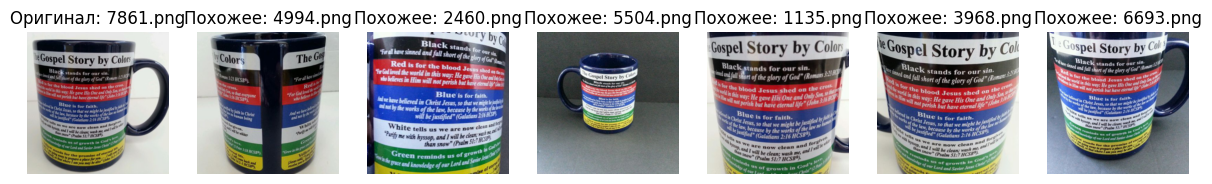

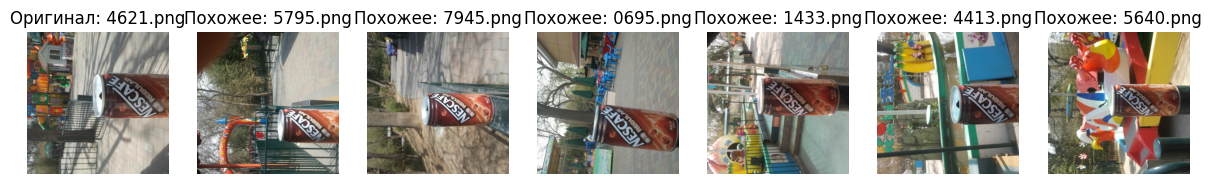

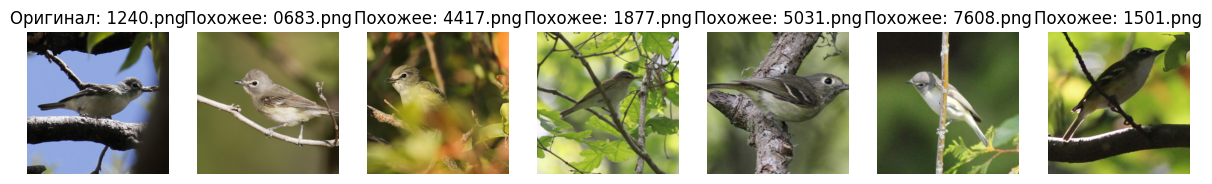

In [11]:
display_similar_images(similar_images, features_dict)
display_similar_images(similar_images, features_dict)
display_similar_images(similar_images, features_dict)